In [139]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import matplotlib.pyplot as plt
import time
import random as rd
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm 



In [140]:
df = pd.read_excel('data_PTV_Fil_rouge/2_detail_table_customers.xls')

In [141]:
df

,ROUTE_ID,CUSTOMER_NUMBER,CUSTOMER_CODE,CUSTOMER_LATITUDE,CUSTOMER_LONGITUDE,CUSTOMER_TIME_WINDOW_FROM_MIN,CUSTOMER_TIME_WINDOW_TO_MIN,NUMBER_OF_ARTICLES,TOTAL_WEIGHT_KG,TOTAL_VOLUME_M3,CUSTOMER_DELIVERY_SERVICE_TIME_MIN,
0,2946091,1,138087,43.413050,17.875880,480,900,42.0,64.318000,0.320000,19.94,
1,2946091,2,138157,43.135963,17.776839,480,900,14.0,17.553000,0.046000,11.36,
2,2946091,3,26,43.469078,17.337022,481,961,4.0,6.378000,0.041000,8.73,
3,2946091,4,478,43.707160,17.222900,481,961,5.0,16.375000,0.046000,9.10,
4,2946091,5,921127,43.082228,17.960037,480,840,16.0,18.939000,0.074000,11.99,
...,...,...,...,...,...,...,...,...,...,...,...,...
1153,3044702,87,1938,43.257390,18.113070,481,961,5.0,7.886550,0.037284,12.50,
1154,3044702,88,131742,42.869100,18.425580,481,961,15.0,37.681000,0.355000,17.50,
1155,3044702,89,1805,43.381760,17.591550,481,961,2.0,114.972000,0.140000,11.00,
1156,3044702,90,957,44.073827,17.448408,481,961,8.0,56.385000,0.190000,14.00,


In [142]:
df['CUSTOMER_CODE'].nunique()

573

In [143]:
from math import radians, cos,sin,  atan2, sqrt
from tqdm.notebook import trange
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.img_tiles import OSM


class Lieu():
    R_TERRE = 6373.0
    def __init__(self , id : int, longitude : float, latitude : float):
        self.id = id
        self.longitude = longitude
        self.latitude = latitude

    def distance(self, other ) -> float:
        
        dlat = radians(other.latitude - self.latitude)
        dlon = radians(other.longitude - self.longitude)
        a = sin(dlat / 2)**2 + cos(self.latitude) * cos(other.latitude) * sin(dlon / 2)**2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))
        return self.R_TERRE * c

    def __str__(self):
        return f'Lieu {self.id}'
    
class Client(Lieu):
    def __init__(self, id : int, longitude : float, latitude : float,  demande : float):
        super().__init__(id, longitude, latitude)
        self.demande = demande
    
    def __str__(self):
        return f'{self.id}'
    
    def __repr__(self):
        return f'{self.id}'
    
class Depot(Lieu):
    def __init__(self, id : int, longitude : float, latitude : float):
        super().__init__(id, longitude, latitude)

    def __str__(self):
        return f'Depot {self.id}'

    def __repr__(self):
        return f'Depot {self.id}'
    

class Vehicule() :
    def __init__(self, id : int, capacite : float):
        self.id = id
        self.capacite = capacite

    def __str__(self):
        return str(self.id)

    def __repr__(self):
        return str(self.id)
    
    def mesure_load(self, actions : list[Lieu]) -> float  :
        load =self.capacite
        for action in actions :
            if isinstance(action, Client) :
                load -= action.demande
            elif isinstance(action, Depot) :
                load = self.capacite
        return load

    def mesure_distance(self, actions : list[Lieu]) -> float :
        if len(actions) <=1 : return 0
        d = 0
        for i in range(len(actions)-1) :
            d += actions[i].distance(actions[i+1])
        return d
        


class SolutionFinale():
    def __init__(self, schedule : dict[Vehicule,list[Lieu]], probleme): 
        self.schedule = schedule
        self.probleme = probleme

    @property   
    def nb_vehicles(self) -> int :
        return len(self.schedule)

    def impose_capacity_constraint(self):
        for vehicule in self.schedule :
            N= len(self.schedule[vehicule])
            if N == 0 : pass
            done = []
            to_do = self.schedule[vehicule]
            while to_do :
                next = to_do.pop(0)
                if isinstance(next, Client) and next.demande > vehicule.mesure_load(done) :
                    done.append(self.probleme.depot)
                done.append(next)
            self.schedule[vehicule] = done


    def score (self) -> float :
        self.impose_capacity_constraint()
        for vehicule in self.schedule :
            if len(self.schedule[vehicule]) >0 and not isinstance(self.schedule[vehicule][-1], Depot) : 
                self.schedule[vehicule].append(self.probleme.depot)
            if len(self.schedule[vehicule]) >0 and not isinstance(self.schedule[vehicule][0], Depot) :
                self.schedule[vehicule].insert(0, self.probleme.depot)
        c = self.nb_vehicles * self.probleme.cout_vehicule
        distances = [vehicule.mesure_distance(self.schedule[vehicule]) for vehicule in self.schedule]
        c += sum(distances) +max(distances)*self.nb_vehicles
        return c

    def score_2(self) -> float:
        if self._score is not None:
            return self._score  # Retourner le score précédemment calculé si disponible

        total_cost = self.nb_vehicles * self.probleme.cout_vehicule

        for vehicle, path in self.schedule.items():
            # Créer une copie temporaire de l'itinéraire pour le véhicule
            temp_path = [self.probleme.depot] if not isinstance(path[0], Depot) else path[:]
            if len(path) > 0 and not isinstance(path[-1], Depot):
                temp_path.append(self.probleme.depot)

            # Calculer la distance pour le chemin temporaire
            distance = vehicle.mesure_distance(temp_path)
            total_cost += distance

        self._score = total_cost  # Mémoriser le score calculé
        return self._score

    def __str__(self):
        return str(self.schedule)
    
    def plot(self):
        self.impose_capacity_constraint()
        print(self.nb_vehicles)
        print()
        for vehicule in self.schedule :
            if len(self.schedule[vehicule]) > 1 and not isinstance(self.schedule[vehicule][-1], Depot) : 
                self.schedule[vehicule].append(self.probleme.depot)
            if len(self.schedule[vehicule]) > 1 and not isinstance(self.schedule[vehicule][0], Depot) :
                self.schedule[vehicule].insert(0, self.probleme.depot)
        fig = plt.figure(figsize = (7,7))
        ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
        imagery = OSM()
        ax.add_image(imagery, 9)
        for vehicule in self.schedule :
            if len(self.schedule[vehicule]) > 1 :
                ax.plot([l.longitude for l in self.schedule[vehicule]], [l.latitude for l in self.schedule[vehicule]])
                #for l in self.schedule[vehicule] :
                    #plt.text(l.longitude , l.latitude, str(l.id), horizontalalignment='center',verticalalignment='center')
        ax.plot(self.probleme.depot.longitude, self.probleme.depot.latitude, 'ro')
        plt.figure()
        i = 0
        for vehicule in self.schedule :
            if len(self.schedule[vehicule])>1 :
                origin = self.schedule[vehicule][0]
                time = 0
                #plt.text(0,len(self.schedule)-i, self.schedule[vehicule][0], horizontalalignment='center',verticalalignment='center')
                for j in range(1,len(self.schedule[vehicule])) :
                    plt.plot([time, time + origin.distance(self.schedule[vehicule][j])], [len(self.schedule)-i-j/len(self.schedule[vehicule]),len(self.schedule)-i-j/len(self.schedule[vehicule])])
                    #plt.text(time + origin.distance(self.schedule[vehicule][j]), len(self.schedule)-i-(j+0.5)/len(self.schedule[vehicule]), self.schedule[vehicule][j], horizontalalignment='center',verticalalignment='center')
                    time += origin.distance(self.schedule[vehicule][j])
                    origin = self.schedule[vehicule][j]
                i+=1
        plt.figure()



        


class SimpleVRP() :
    def __init__(self, clients : list[Client], depot : Depot, cout_vehicule : float, capacite_vehicule : float):
        self.clients = clients
        self.cout_vehicule = cout_vehicule
        self.depot = depot
        self.capacite_vehicule = capacite_vehicule
    
    def gen_random_solution(self, n_transports: int):
        rd.shuffle(self.clients)
        return Solution(self.clients,n_transports, self)
    

    def genetic(self, N_pop : int, n_iter: int, initial_n_transports: int, Pcross : float,Pmut : float) -> tuple[SolutionFinale, list[float]]:
        P=[]
        for i in range(N_pop):
            P.append(self.gen_random_solution(initial_n_transports))
        generation_best : list[Solution] = []        
        for i in trange(n_iter):
            S = sorted(P, key = lambda x : x.score())
            S = S[:N_pop]
            generation_best.append(S[0])
            nex_gen : list[Solution]= []
            for p1, p2 in zip(S[::2], S[1::2]):
                nex_gen.extend(p1.cross(p2, Pcross))
            rd.shuffle(nex_gen)
            P: list [Solution] = [x.mutate(Pmut) for x in nex_gen]
        S = sorted(P, key = lambda x : x.score())
        generation_best.append(S[0])
        best_of_the_best = min(generation_best,  key = lambda x : x.score() )
        return best_of_the_best.final, list(map(lambda x : x.score(), generation_best))


    def genetic_plot_and_perf_for_random_parameters(self):
        Pmut = rd.random()
        Pcross = rd.random()
        N_pop = 5*len(self.clients)
        n_iter = 5*N_pop
        initial_n_transports = rd.randint(1, 10)
        sol, conv = self.genetic(N_pop, n_iter, initial_n_transports, Pcross, Pmut)
        print(sol.score())
        sol.plot()
        plt.semilogy(conv)        
        plt.show()



class Solution():
    def __init__(self, chromosome : list[Client], N_vehicules : int, probleme : SimpleVRP):
        self.chromosome = chromosome
        self.N_vehicules = N_vehicules
        self.probleme = probleme
    
    def __str__(self):
        return f"{[str(l) for l in self.chromosome]} by {self.N_vehicules} vehicles"

    def mutate(self, p):
        if rd.random() > p : 
            i1 = rd.randint(0,len(self.chromosome)-1)
            i2 = rd.randint(0,len(self.chromosome)-1)
            self.chromosome[i1], self.chromosome[i2] = self.chromosome[i2], self.chromosome[i1]
        if rd.random()> p :
            if rd.random() > 0.5 : 
                self.N_vehicules += 1
            else : 
                if self.N_vehicules>1:
                    self.N_vehicules -= 1
        return self
        
    def cross(self, other , p):
        if self.probleme != other.probleme :
            raise ValueError("The two solutions must be from the same problem")
        if rd.random() > p :
            a = rd.randint(0,len(self.chromosome))
            fils1 = [None]*len(self.chromosome)
            fils2 = [None]*len(self.chromosome)
            fils3 = [None]*len(self.chromosome)
            fils4 = [None]*len(self.chromosome)
            fils1[:a]=self.chromosome[:a]
            fils2[:a]=other.chromosome[:a]
            fils3[a:]=self.chromosome[a:]
            fils4[a:]=other.chromosome[a:]
            i=0
            for t in other.chromosome :
                if t not in fils1 :
                    fils1[a+i]=t
                    i+=1
            i=0
            for t in self.chromosome :
                if t not in fils2 :
                    fils2[a+i]=t
                    i+=1
            i=0
            for t in other.chromosome :
                if t not in fils3 :
                    fils3[i]=t
                    i+=1
            i=0
            for t in self.chromosome :
                if t not in fils4 :
                    fils4[i]=t
                    i+=1

            return [Solution(fils1, self.N_vehicules, self.probleme), Solution(fils2, other.N_vehicules, self.probleme), Solution(fils3, self.N_vehicules, self.probleme), Solution(fils4, other.N_vehicules, self.probleme)]
        else : 
            return [self, other]
        
    @property
    def final(self):
        vehicules = [Vehicule(i, self.probleme.capacite_vehicule) for i in range(self.N_vehicules)]
        res = {v : [] for v in vehicules}
        for i, c in enumerate(self.chromosome) :
            res[vehicules[i%self.N_vehicules]].append(c)
        res = {key : res[key] for key in res if len(res[key])>0}
        return SolutionFinale(res, self.probleme)


    def score(self) -> float :        
        return self.final.score()

In [144]:
# Fonction pour générer une solution initiale (aléatoire)
def generate_initial_solution(clients, depot, vehicles):
    schedule = {}
    for v in vehicles:
        schedule[v] = [depot] + rd.sample(clients, len(clients)) + [depot]
    return SolutionFinale(schedule, SimpleVRP(clients, depot, 10.0, 100.0))  # Coûts fictifs

# Fonction pour générer des solutions voisines
def generate_neighbors(solution, depot, num_neighbors=10):
    neighbors = []
    for _ in range(num_neighbors):
        new_schedule = {}
        for v, path in solution.schedule.items():
            if len(path) > 2:  # Ignorer les véhicules sans clients
                # Échanger deux clients aléatoirement pour créer une nouvelle solution
                new_path = path[:]
                idx1, idx2 = rd.sample(range(1, len(path)-1), 2)  # Éviter le dépôt
                new_path[idx1], new_path[idx2] = new_path[idx2], new_path[idx1]
                new_schedule[v] = new_path
            else:
                new_schedule[v] = path[:]
        neighbors.append(SolutionFinale(new_schedule, solution.probleme))
    return neighbors

## Tabou

In [145]:
def tabu_search(initial_solution, depot, tabu_size=10, num_iterations=100, num_neighbors=10):
    best_solution = initial_solution
    current_solution = initial_solution
    tabu_list = []

    with tqdm(total=num_iterations, desc="Progression de la Recherche Tabou") as bar:
        for iteration in range(num_iterations):
            neighbors = generate_neighbors(current_solution, depot, num_neighbors)
            
            # Trier les voisins en fonction de leur score
            neighbors = sorted(neighbors, key=lambda x: x.score(), reverse=False)
            
            # Trouver le meilleur voisin qui n'est pas dans la liste tabou
            found = False
            for neighbor in neighbors:
                if neighbor not in tabu_list and (best_solution is None or neighbor.score() < best_solution.score()):
                    current_solution = neighbor
                    if neighbor.score() < best_solution.score():
                        best_solution = neighbor
                    found = True
                    break
            
            if found:
                # Ajouter la solution actuelle à la liste tabou
                tabu_list.append(current_solution)
                if len(tabu_list) > tabu_size:
                    tabu_list.pop(0)
            
            # Mise à jour de la barre de progression
            bar.update(1)
            bar.set_postfix({'Meilleur score': best_solution.score()}, refresh=False)

    return best_solution


## Recuit Simulé

In [146]:
def simulated_annealing(initial_solution: Solution, depot, nb_iter: int, n_transports: int, t0: float, cooling: float):
    
    '''
    Méthode du Recuit Simulé
    
    Arguments
    ---------
    initial_solution: solution de départ
    nb_iter: nombre d'itérations max de la fonction
    n_transports: nombre de véhicules
    t0: température initiale du système
    cooling: coefficient de refroidissement du système
    '''
    
    iter = 0
    
    #Liste des différentes valeurs de score
    plot_list = []
    plot_temp = []
    plot_energy = []
    
    #Différentes solutions utilisées dans la méthode
    s: Solution = initial_solution
    s_: Solution = s
        
    t: float = t0
        
    with tqdm(total=nb_iter, desc="Progression de la Recherche RS") as bar:
        while iter < nb_iter:

            plot_list.append(s.score())
            plot_temp.append(t)

            iter += 1
            #Génération d'un voisin et comparaison
            voisins = generate_neighbors(s, depot, 1)
            s_ = voisins[0]
            f1: float = s_.score()
            f2: float = s.score()
            df: float = f1 - f2
            print(df)

            if df <= 0:
                s = s_
                plot_energy.append(0)

            else:
                #Fonction de probabilité en fonction de la température
                prob: float = np.exp(-df / t)
                plot_energy.append(prob)
                q: float = rd.random()
                if q < prob:
                    s = s_

            t *= (1 - cooling)
                
            # Mise à jour de la barre de progression
            bar.update(1)
            bar.set_postfix({'Meilleur score': s.score()}, refresh=False)
                
                
        
    return s, plot_list, plot_temp, plot_energy

In [147]:
def rs_plot(initial_solution: Solution, depot):
    
    '''
    Applique la méthode du RS et affiche les résultats des différents scores
    
    Arguments
    ---------
    initial_solution: solution de départ aléatoire
    t0: température initiale
    colling: coefficient de refroidissement du système
    '''
    
    N_pop = 5 * len(initial_solution.probleme.clients)
    n_iter = 5 * N_pop
    n_transports: int = rd.randint(1, 10)
    sol, plot_list, plot_temp, plot_energy = simulated_annealing(initial_solution, depot, n_iter, n_transports, 1000, 0.1)
    print(sol.score())
    sol.plot()
    
    fig, axs = plt.subplots()
    axs.set(xlabel = 'Itérations', ylabel='Score')
    axs.plot(plot_list)
    
    fig, axs = plt.subplots()
    axs.set(xlabel = 'Itérations', ylabel='Température')
    axs.plot(plot_temp)
    
    fig, axs = plt.subplots()
    axs.set(xlabel = 'Itérations', ylabel='Higgs energy')
    axs.plot(plot_energy)

## Test sur petite échelle

In [148]:
# Définir des clients et un dépôt de manière arbitraire pour le test
clients = [Client(i, rd.uniform(0, 5), rd.uniform(0, 5), rd.randint(1, 10)) for i in range(1, 6)]
depot = Depot(0, 2.5, 2.5)  # Position centrale

# Définir un véhicule avec une capacité arbitraire
vehicles = [Vehicule(i, 20) for i in range(2)]  # Deux véhicules pour cet exemple

# Fonction pour générer une solution initiale (pour le test)
def generate_initial_solution(clients, depot, vehicles):
    schedule = {vehicle: [depot] + rd.sample(clients, len(clients)) + [depot] for vehicle in vehicles}
    return SolutionFinale(schedule, SimpleVRP(clients, depot, cout_vehicule=10.0, capacite_vehicule=20.0))  # Coûts fictifs

initial_solution = generate_initial_solution(clients, depot, vehicles)

### Test Génétique

  0%|          | 0/125 [00:00<?, ?it/s]

1807.4993129609375
1



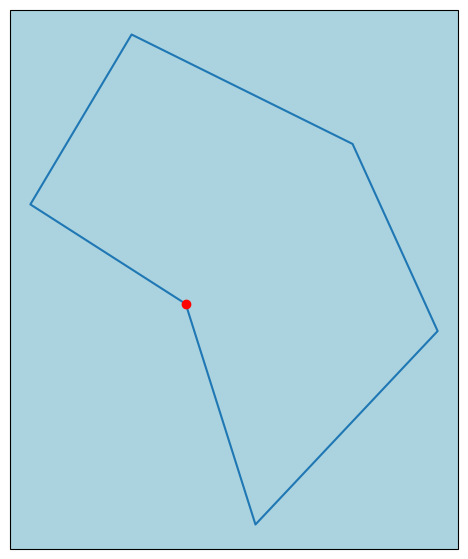

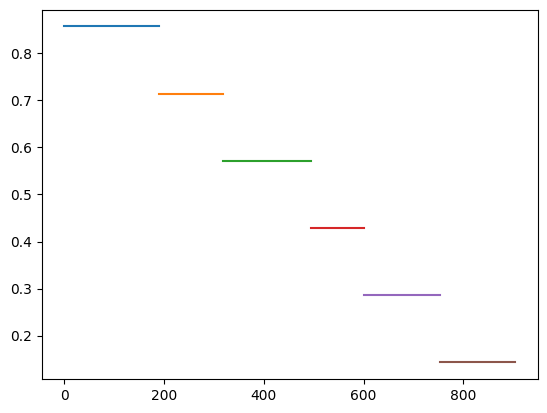

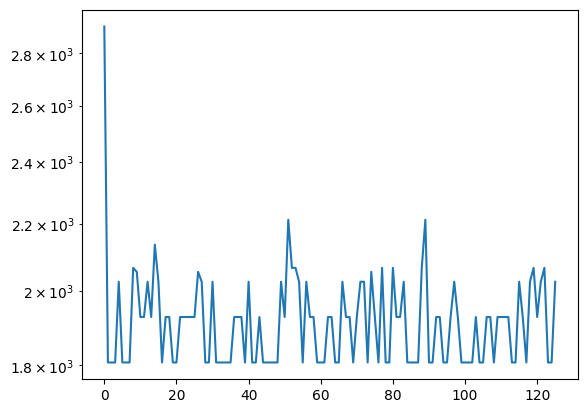

In [149]:
vrp = SimpleVRP(clients, depot, 0, 100)
vrp.genetic_plot_and_perf_for_random_parameters()

### Test Tabou

Progression de la Recherche Tabou:   0%|          | 0/50 [00:00<?, ?it/s]

Meilleure solution trouvée avec un coût de : 4329.447349717222
2



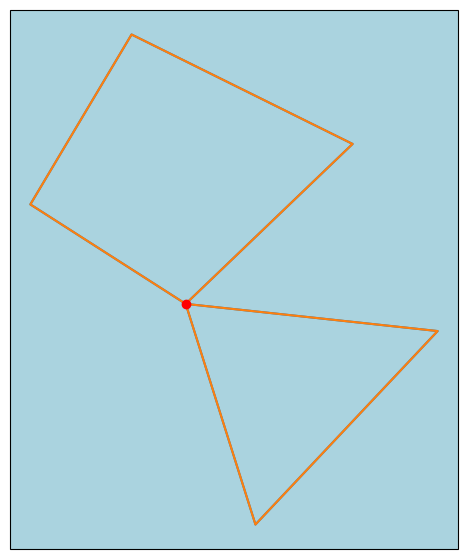

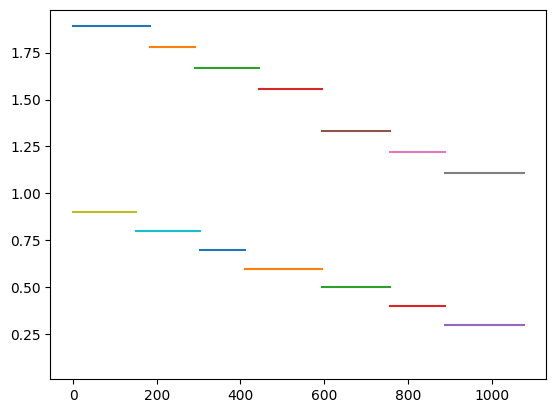

<Figure size 640x480 with 0 Axes>

In [150]:
best_solution = tabu_search(initial_solution, depot, tabu_size=10, num_iterations=50, num_neighbors=15)

print("Meilleure solution trouvée avec un coût de :", best_solution.score())
best_solution.plot()

### Test RS

Progression de la Recherche RS:   0%|          | 0/125 [00:00<?, ?it/s]

-370.9551217316057
811.9735782294229
-87.42494926328618
-137.3920850042632
308.1703669830258
239.10657038851605
-476.86861470364147
267.6375110394174
-457.3672652795958
-117.45003770077074
562.5379315750206
827.9289828529927
668.2561963049275
463.2793686013474
32.7595939570665
-716.6598140307669
442.09580844682023
1458.206534393723
1234.7515084301576
839.3380072624959
363.8793728120563
743.5565738149162
893.769277567696
1366.7388373314216
852.1345133014629
1086.2554960814123
782.5726319678752
-232.2127045449961
1072.8472368493794
693.0861387984114
559.1386666160251
601.1917357489856
910.7279712390155
1099.5683292360009
511.40163361334817
1066.4258004806634
850.0433088328655
558.9803115532541
0.0
1184.7942908142031
453.9690980280757
998.5393211816099
850.0433088328655
737.9651311273683
1487.297795387859
1186.5328073990522
1318.9748360200538
1100.9185608455355
272.588201809187
850.0433088328655
0.0
1414.9314532146127
731.2834496892465
621.7489383759785
0.0
38.302123769513855
1186.5328073

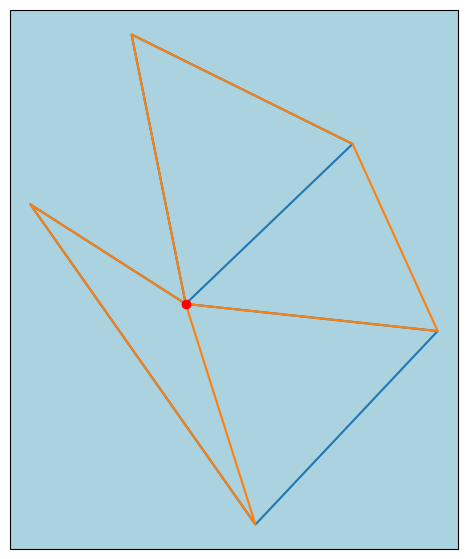

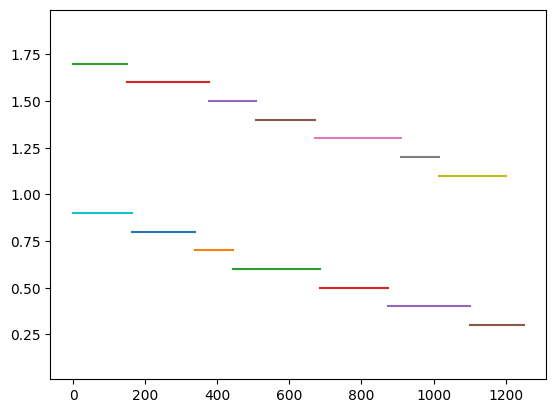

<Figure size 640x480 with 0 Axes>

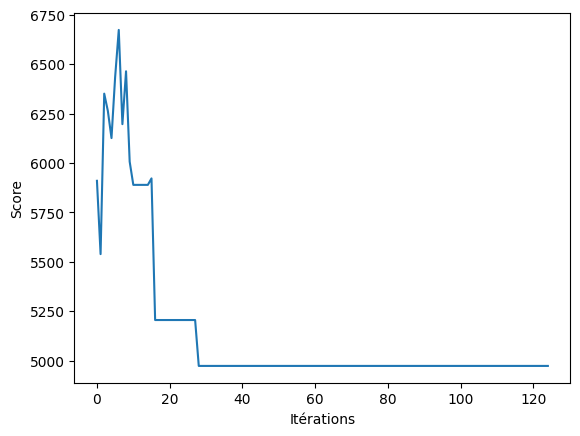

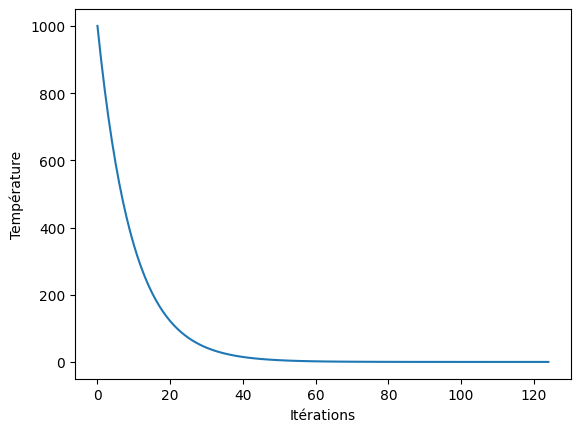

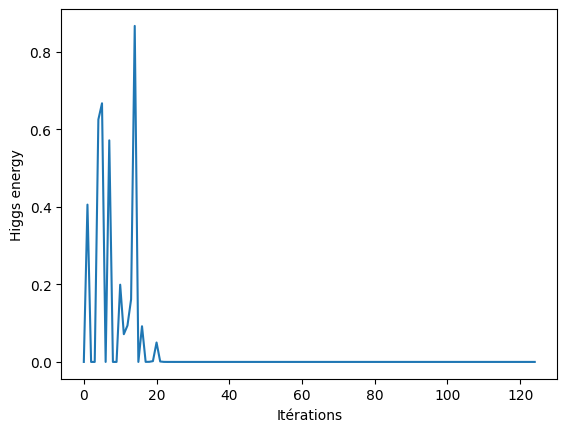

In [151]:
rs_plot(initial_solution, depot)

## Test sur Problème

In [152]:
import pandas as pd

In [153]:
customers_df = pd.read_excel('data_PTV_Fil_rouge/2_detail_table_customers.xls')
vehicles_df = pd.read_excel('data_PTV_Fil_rouge/3_detail_table_vehicles.xls')

vehicle_weight = vehicles_df.VEHICLE_TOTAL_WEIGHT_KG.mean()
print(vehicle_weight)


customers = [Client(*row) for row in customers_df.groupby(['CUSTOMER_CODE', 'CUSTOMER_LONGITUDE','CUSTOMER_LATITUDE'], as_index=False).aggregate({'TOTAL_WEIGHT_KG': 'mean'}).itertuples(index=False)]

coords = customers_df[['CUSTOMER_LONGITUDE','CUSTOMER_LATITUDE']].drop_duplicates().aggregate({'CUSTOMER_LONGITUDE' : 'mean', 'CUSTOMER_LATITUDE': 'mean'})
depot = Depot(0, coords['CUSTOMER_LONGITUDE'], coords['CUSTOMER_LATITUDE'])

4540.329268292683


In [154]:


VRP = SimpleVRP(clients=rd.sample(customers,70), depot=depot, cout_vehicule=0, capacite_vehicule=vehicle_weight)

#VRP.genetic_plot_and_perf_for_random_parameters()

In [155]:
from models import SMA_VRP, GeneticAgent
import random as rd

vrp = SMA_VRP(clients=rd.sample(customers,70), depot=depot, cout_vehicule=0, capacite_vehicule=vehicle_weight)
